<a href="https://colab.research.google.com/github/satrioadzi/visi-komputer-TI-2A/blob/main/praktek_regresi_gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

# Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
 r = np.random.randint(min_r, max_r + 1) # radius acak
 img = np.zeros((img_size, img_size), dtype=np.uint8)
 cx = np.random.randint(r, img_size - r) # center-x
 cy = np.random.randint(r, img_size - r) # center-y
 cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
 img = (img / 255.0).astype(np.float32)
 # 3-channel biar kompatibel CNN
 img3 = np.stack([img, img, img], axis=-1)
 return img3, float(r), (cx, cy)


# Tampilkan Contoh Gambar TANPA Label

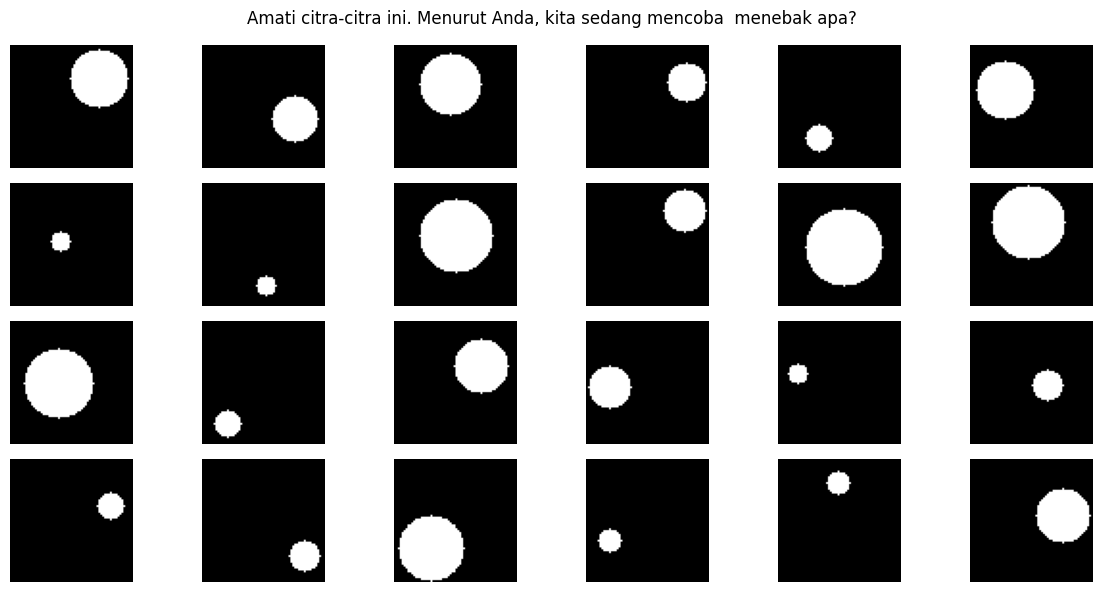

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]
# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
 plt.subplot(rows, cols, i+1)
 plt.imshow(imgs[i].squeeze(), cmap='gray')
 plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba  menebak apa?")
plt.tight_layout()
plt.show()


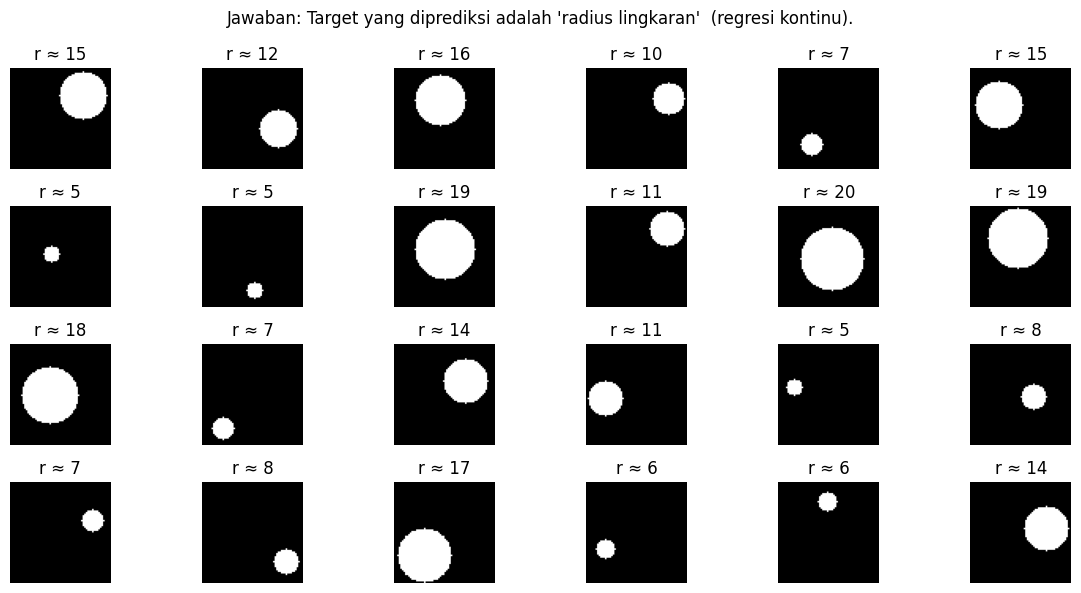

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap  subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
 plt.subplot(rows, cols, i+1)
 plt.imshow(imgs[i].squeeze(), cmap='gray')
 plt.title(f"r ≈ {int(rads[i])}")
 plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran'  (regresi kontinu).")
plt.tight_layout()
plt.show()


# Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

# Mengunggah kaggle.json ke Colab

In [ ]:
from google.colab import files

# Unggah file kaggle.json dari komputer
uploaded = files.upload()


Saving kaggle.json to kaggle (1).json


In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
 os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
 shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
 os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
 !pip -q install kaggle
 print("✅ Kaggle API siap digunakan.")
else:
 print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


# Mengunduh Dataset UTKFace dari Kaggle

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ Dataset UTKFace berhasil diekstrak.


# Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


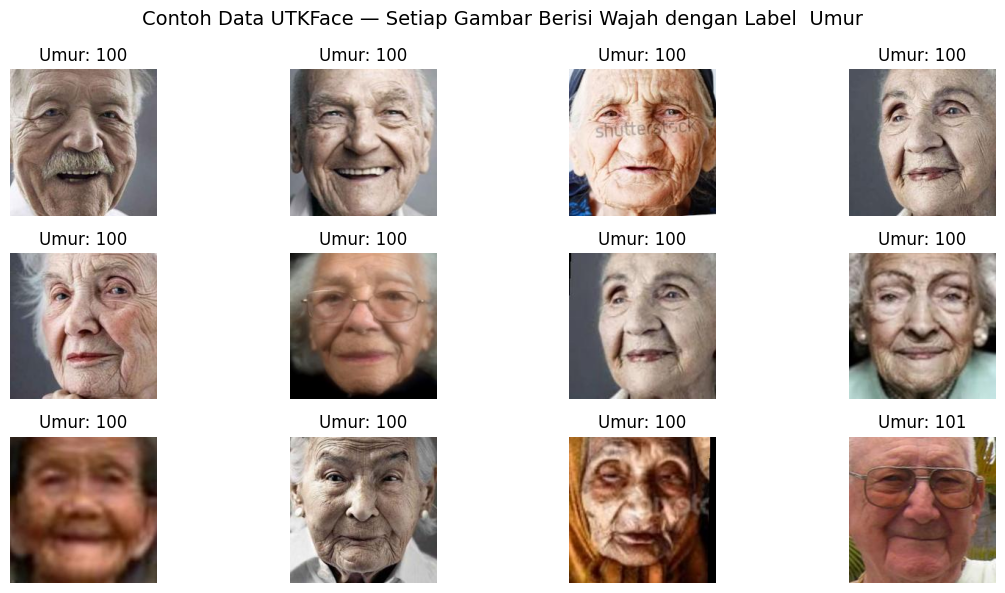

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
 # Ambil umur dari nama file
 age = int(os.path.basename(f).split("_")[0])
 img = Image.open(f)
 plt.subplot(3, 4, i + 1)
 plt.imshow(img)
 plt.title(f"Umur: {age}")
 plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label  Umur", fontsize=14)
plt.tight_layout()
plt.show()


# Dataset untuk Model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
def parse_age_from_name(fp):
 return int(os.path.basename(fp).split('_')[0])
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(  files, ages, test_size=0.2, random_state=42)
IMG_SIZE = 160
def load_img(fp, label):
 img = tf.io.read_file(fp)
 img = tf.image.decode_jpeg(img, channels=3)
 img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
 return img / 255.0, label
train_ds = tf.data.Dataset.from_tensor_slices((train_files,  y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files,  y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


# Membangun Model dengan Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else  "CPU")
# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
 include_top=False,
 input_shape=(IMG_SIZE, IMG_SIZE, 3),
 weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone
# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)
# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
 loss='mse', metrics=['mae'])
model.summary()


Hardware: GPU


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - loss: 335.2481 - mae: 13.4400 - val_loss: 158.4723 - val_mae: 9.6012 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 154.8520 - mae: 9.2593 - val_loss: 145.1615 - val_mae: 9.0533 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 146.5164 - mae: 8.9396 - val_loss: 140.7474 - val_mae: 8.8625 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 141.5776 - mae: 8.7296 - val_loss: 138.0547 - val_mae: 8.7192 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 136.8858 - mae: 8.6192 - val_loss: 136.8187 - val_mae: 8.6643 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 134.2366 - mae: 8.4805 - val_loss: 134.8694 - val_mae: 8.5238 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 133.8097 - mae: 8.4851 - val_loss: 135.7011 - va

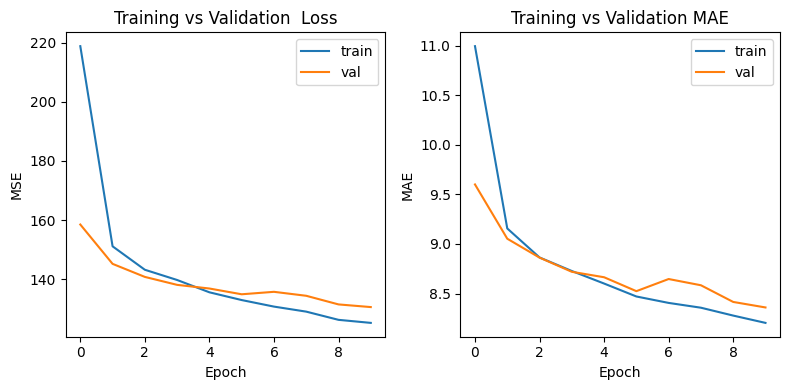

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
 tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
 tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
 train_ds,
 validation_data=test_ds,
 epochs=10,
 callbacks=cb,
 verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation  Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - loss: 188.3825 - mae: 10.0820 - val_loss: 143.1933 - val_mae: 8.9029 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 78.5838 - mae: 6.6001 - val_loss: 123.9026 - val_mae: 8.5784 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 51.8285 - mae: 5.4353 - val_loss: 118.0739 - val_mae: 8.2727 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 38.7188 - mae: 4.7223 - val_loss: 116.3868 - val_mae: 8.2335 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 30.6510 - mae: 4.2162 - val_loss: 111.1411 - val_mae: 7.6303 - learning_rate: 1.0000e-04


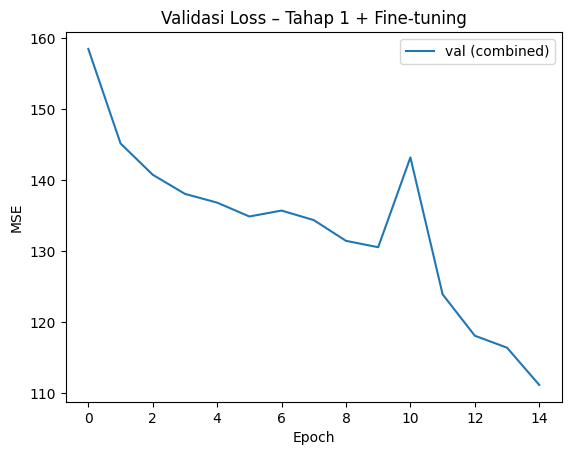

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
 loss='mse', metrics=['mae'])
history_ft = model.fit(
 train_ds,
 validation_data=test_ds,
 epochs=5,
 callbacks=cb,
 verbose=1
)
# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],  label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()


# Evaluasi Akhir (MAE, RMSE, R²)

MAE = 7.63 tahun
RMSE = 10.54 tahun
R² = 0.720


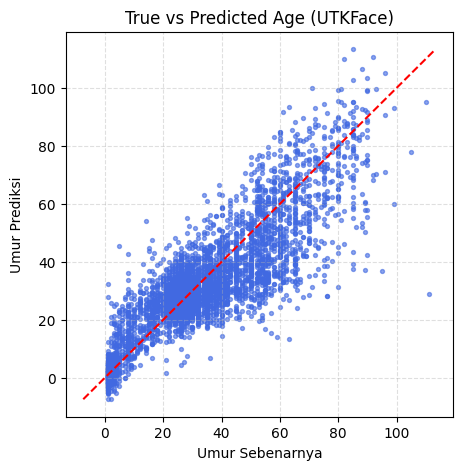

In [ ]:
from math import sqrt
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")
# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


# Melihat Contoh Prediksi Nyata

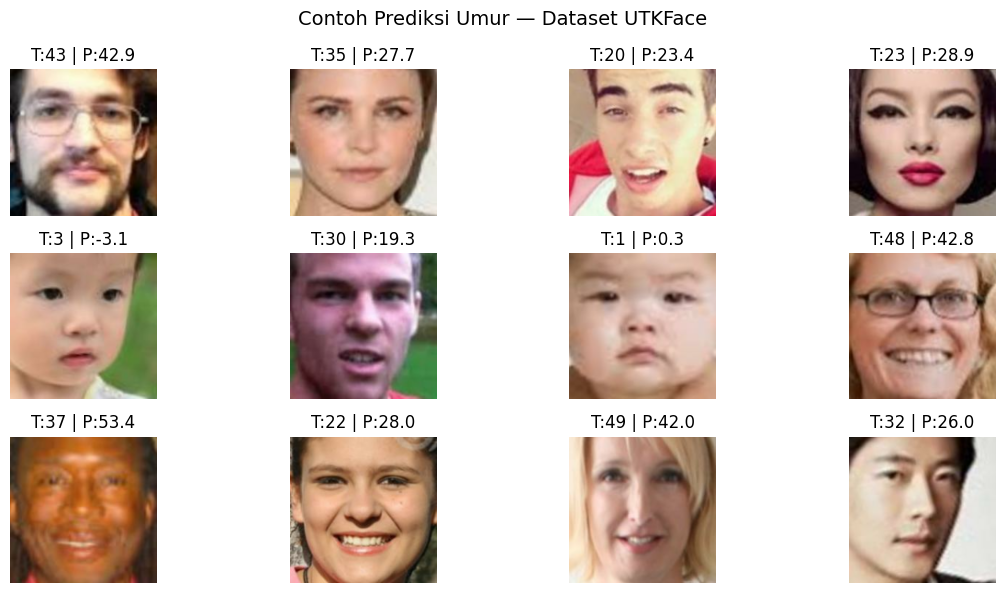

In [ ]:
import random
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
 img = tf.io.read_file(path)
 img = tf.image.decode_jpeg(img, channels=3)
 img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
 true_age = int(os.path.basename(path).split('_')[0])
 pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
 plt.subplot(3,4,i+1)
 plt.imshow(img.numpy())
 plt.title(f"T:{true_age} | P:{pred_age:.1f}")
 plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


# penugasan nomor 3

Silakan unggah satu atau lebih file gambar:


Saving Gambar WhatsApp 2025-10-10 pukul 22.52.42_158ce3a5.jpg to Gambar WhatsApp 2025-10-10 pukul 22.52.42_158ce3a5 (6).jpg


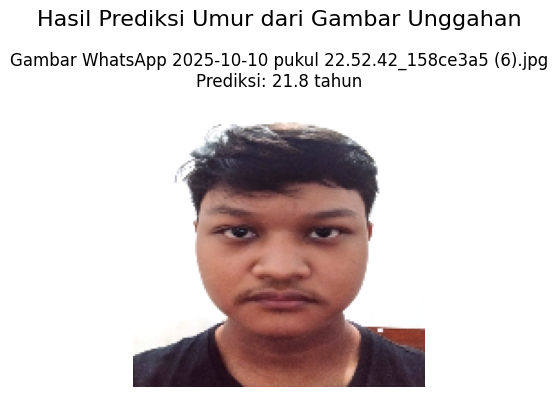

In [ ]:
# Import library yang diperlukan
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- BAGIAN UPLOAD GAMBAR ---
print("Silakan unggah satu atau lebih file gambar:")
# Membuka dialog untuk memilih file dari komputer Anda
uploaded_files = files.upload()

# Cek apakah ada file yang diunggah
if not uploaded_files:
    print("\nTidak ada file yang diunggah. Proses dibatalkan.")
else:
    # Menghitung jumlah file untuk membuat layout plot yang dinamis
    num_files = len(uploaded_files)
    # Menentukan jumlah kolom (misal, maksimal 4 gambar per baris)
    ncols = min(num_files, 4)
    # Menghitung jumlah baris yang dibutuhkan
    nrows = (num_files + ncols - 1) // ncols

    plt.figure(figsize=(ncols * 4, nrows * 4))

    # Looping untuk setiap file yang berhasil diunggah
    for i, (filename, content) in enumerate(uploaded_files.items()):
        # Membaca file gambar dari konten byte yang diunggah
        img = tf.io.decode_image(content, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 200.0
        pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

        # Menampilkan gambar beserta hasil prediksinya
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img.numpy())
        plt.title(f"{filename}\nPrediksi: {pred_age:.1f} tahun")
        plt.axis('off')

    plt.suptitle("Hasil Prediksi Umur dari Gambar Unggahan", fontsize=16)
    plt.tight_layout()
    plt.show()

## Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

# Menyiapkan Kaggle API

In [1]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
 os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
 shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
 os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
 !pip -q install kaggle
 print("✅ Kaggle API siap digunakan.")
else:
 print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving kaggle.json to kaggle.json
✅ Kaggle API siap digunakan.


In [2]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")


✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

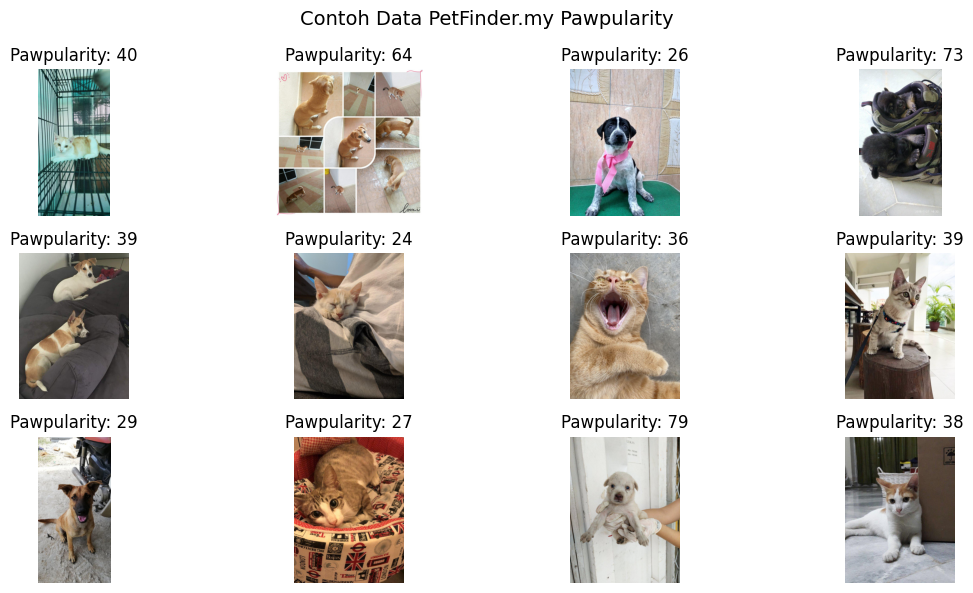

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())
# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
def load_image(path, label):
 img = tf.io.read_file(path)
 img = tf.image.decode_jpeg(img, channels=3)
 img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
 img = tf.cast(img, tf.float32) / 255.0
 return img, tf.cast(label, tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
 .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
 .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
 .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
 .batch(64).prefetch(tf.data.AUTOTUNE)
print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


In [5]:
from tensorflow.keras import layers, models
base = tf.keras.applications.EfficientNetB0(
 include_top=False,
 input_shape=(IMG_SIZE, IMG_SIZE, 3),
 weights='imagenet'
)
base.trainable = False # freeze sementara
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
cb = [
 tf.keras.callbacks.EarlyStopping(patience=3,
restore_best_weights=True),
 tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5) ]
history = model.fit(train_ds, validation_data=val_ds, epochs=10,
 callbacks=cb,
 verbose=1
)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 109s 490ms/step - loss: 828.2040 - mae: 21.9114 - val_loss: 481.5626 - val_mae: 16.3292 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - loss: 428.9919 - mae: 15.3244 - val_loss: 425.7346 - val_mae: 15.0686 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 205ms/step - loss: 400.6682 - mae: 14.8525 - val_loss: 403.0772 - val_mae: 14.5860 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - loss: 373.7846 - mae: 14.3694 - val_loss: 387.6852 - val_mae: 14.6373 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - loss: 364.7598 - mae: 14.1849 - val_loss: 380.1184 - val_mae: 14.3948 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - loss: 336.9250 - mae: 13.5770 - val_loss: 372.8575 - val_mae: 13.9894 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - loss: 340.1023 - mae: 13.5967 - val_

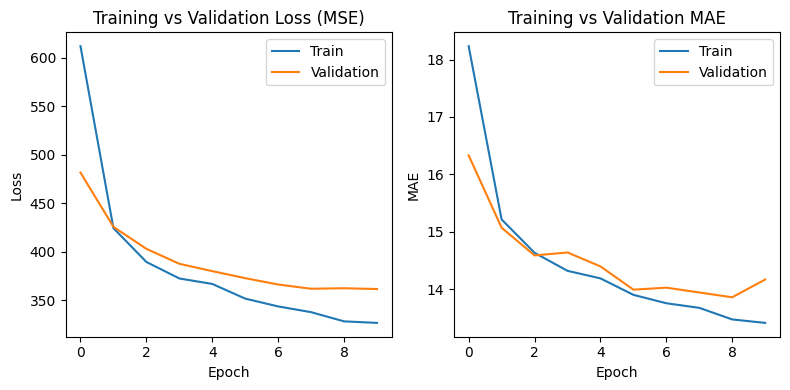

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

MAE = 14.17
RMSE = 19.02
R² = 0.182


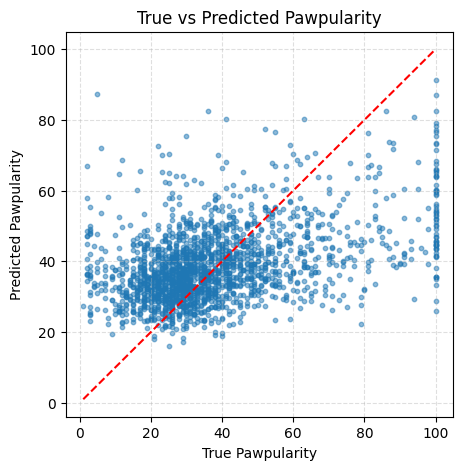

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for  batch in val_ds])
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")
# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

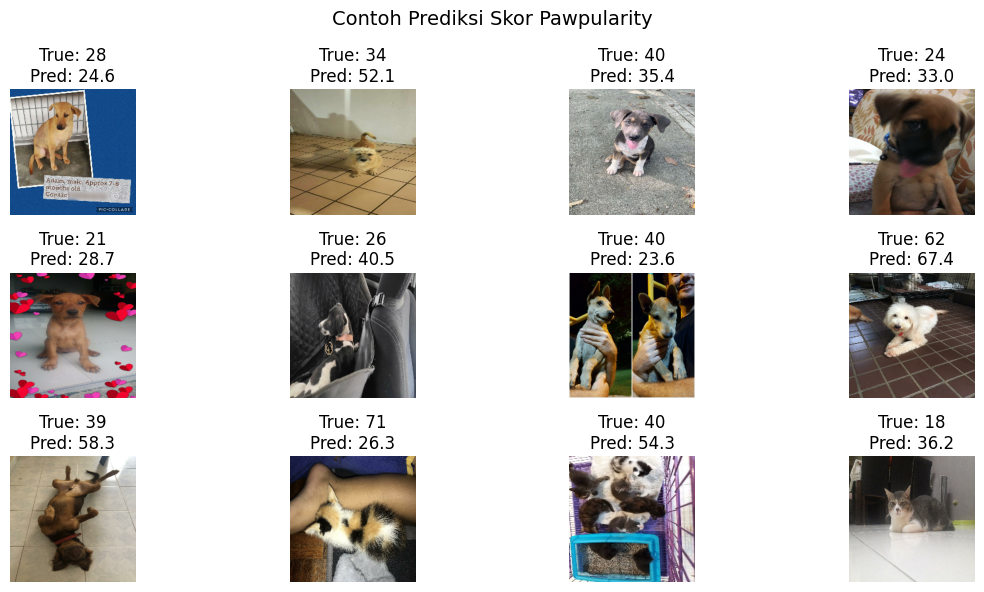

In [9]:
import random
from PIL import Image
sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
 img = tf.io.read_file(row.path)
 img = tf.image.decode_jpeg(img, channels=3)
 img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
 # true_age = int(os.path.basename(path).split('_')[0]) # This line is from the previous notebook, it's not needed here.
 pred = model.predict(tf.expand_dims(load_image(row.path,  row.Pawpularity)[0], 0), verbose=0).ravel()[0]
 plt.subplot(3,4,i+1)
 plt.imshow(img.numpy())
 plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
 plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Silakan unggah satu atau lebih file gambar:


Saving kucing.jpeg to kucing (2).jpeg


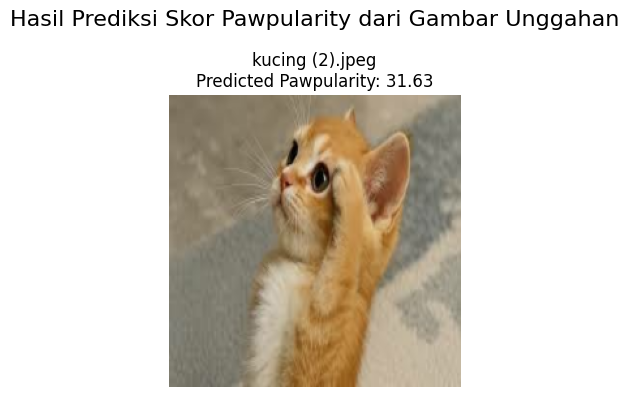

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import os
from google.colab import files

# Save the trained model in the recommended Keras format
model.save('/content/paw_model.keras')

# --- 1. Siapkan gambar pribadi ---
print("Silakan unggah satu atau lebih file gambar:")
uploaded_files = files.upload()

# Cek apakah ada file yang diunggah
if not uploaded_files:
    print("\nTidak ada file yang diunggah. Proses dibatalkan.")
else:
    model = tf.keras.models.load_model('/content/paw_model.keras', compile=False)

    # Menentukan jumlah kolom (misal, maksimal 4 gambar per baris)
    num_files = len(uploaded_files)
    ncols = min(num_files, 4)
    # Menghitung jumlah baris yang dibutuhkan
    nrows = (num_files + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 4, nrows * 4))

    # Looping untuk setiap file yang berhasil diunggah
    for i, (filename, content) in enumerate(uploaded_files.items()):
        # Membaca file gambar dari konten byte yang diunggah
        img = tf.io.decode_image(content, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        img_array = np.expand_dims(img.numpy(), axis=0)

        # --- 4. Prediksi Pawpularity ---
        pred = model.predict(img_array, verbose=0)
        score = float(pred[0][0])

        # --- 5. Visualisasi hasil ---
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img.numpy())
        plt.title(f"{filename}\nPredicted Pawpularity: {score:.2f}")
        plt.axis('off')

    plt.suptitle("Hasil Prediksi Skor Pawpularity dari Gambar Unggahan", fontsize=16)
    plt.tight_layout()
    plt.show()